In [ ]:
try:
  from pytorch_msssim import ssim
except:
  !pip install pytorch_msssim
  from pytorch_msssim import ssim

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import random_split, DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from timeit import default_timer as timer
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
import time
plt.style.use('ggplot')

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_ds_ = torchvision.datasets.CIFAR10('/data/', train=True, transform=transform, download=True)
#train_dataset = DataLoader(train_ds, batch_size= 4, shuffle=False, num_workers=2)
test_ds_ = torchvision.datasets.CIFAR10('/data/', train=False, transform=transform, download=True)
#test_dataset = DataLoader(test_ds, batch_size= 4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Custom_dataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    

  def __len__(self):
    
    return len(self.X)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    x = self.X[idx]
    y0 = self.y[idx]
    return (x, y0)

In [ ]:
class Custom_dataset0(Dataset):
  def __init__(self, train_ds, transform=transforms.GaussianBlur(5, 5)):
    self.train_ds = train_ds
    self.transform = transform
    

  def __len__(self):
    
    return len(self.train_ds)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    x = self.train_ds[idx][0]
    y = self.transform(x)
    return (y, x)

In [ ]:
def Visualization(results):
  values = list(results.values())
  labels = list(results.keys())
  n = len(values[0])
  plt.figure(figsize=(15, 10))
  for i in range(len(labels)):
    plt.subplot(2, len(labels)//2, i + 1)
    plt.plot(np.linspace(0,n,n), values[i])
    plt.title(labels[i])
  plt.show()

In [ ]:
train_data_, val_data_ = train_test_split(train_ds_, shuffle=True)

In [ ]:
train_ds = Custom_dataset0(train_data_)
val_ds = Custom_dataset0(val_data_)
test_ds = Custom_dataset0(test_ds_)

In [ ]:
batch_size = 1
train_blur_clear = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=2)
val_blur_clear = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_blur_clear = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
images = iter(train_blur_clear)
blur_images, clear_images = images.next()

In [ ]:
ssim(blur_images, clear_images, 1)

tensor(0.4670)

In [ ]:
blur_images.shape

torch.Size([1, 3, 32, 32])

In [ ]:
def show(img):
  img = img.detach().numpy()
  img = np.transpose(img, (1,2,0))
  plt.imshow(img)


def display(b_images, cl_images, pred_image=None):
  labels_clear = ['Original Image']*len(cl_images)
  labels_blur = ['Blur Image']*len(b_images)
  labels_pred = ['Predicted Image']*len(b_images)

  if pred_image is not None:
    labels = [labels_clear[0], labels_blur[0], labels_pred[0]]
    img = [cl_images[0], b_images[0], pred_image[0]]
    plt.figure(figsize=(15,15))

  else:
    labels = [labels_clear[0], labels_blur[0]]
    img = [cl_images[0], b_images[0]]
    plt.figure(figsize=(10,10))


  
  n = len(labels)
  for i in range(n):
    plt.subplot(1,n, i+1)
    plt.title(labels[i])
    show(img[i]*0.5+0.5)
    plt.axis('off')
  plt.show()

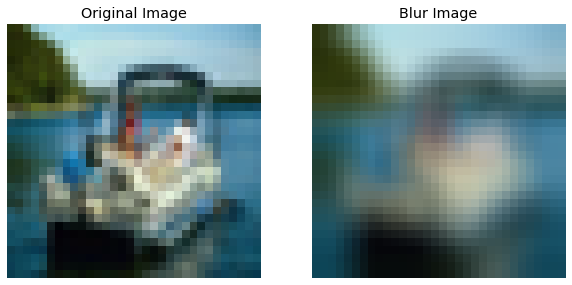

In [ ]:
display(blur_images, clear_images)

In [ ]:
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')

All good, a Gpu is available




```
# This is formatted as code
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
```





```
# This is formatted as code
class Attention(nn.Module):
    def __init__(self, in_ch, out_ch, stride, padding):
        super(Attention, self).__init__()
        self.func = nn.Conv2d(in_ch, out_ch, 1, stride=stride, padding=padding)

    def forward(self, X):
        f = self.func(X)
        g = self.func(X)
        h = self.func(X)

        f_transpose = torch.transpose(f, 2, 3)
        fg = F.softmax(f @ g, dim=-1)
        fgh = fg @ h
        return fgh
```



In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
       
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1) 

In [ ]:
class RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(RDB, self).__init__()
        self.layers = nn.Sequential(*[DenseLayer(in_channels + growth_rate * i, growth_rate)\
         for i in range(num_layers)])

        # local feature fusion
        # self.lff = nn.Conv2d(in_channels + growth_rate * num_layers, growth_rate, kernel_size=1)
        
        self.lff = nn.Conv2d(in_channels + growth_rate * num_layers, growth_rate, kernel_size=1)
        

    def forward(self, x):
        return x + self.lff(self.layers(x))  # local residual learning

In [ ]:
class RDN(nn.Module):
    def __init__(self, scale_factor, num_channels, num_features, growth_rate, num_blocks, num_layers):
        super(RDN, self).__init__()
        self.G0 = num_features
        self.G = growth_rate
        self.D = num_blocks
        self.C = num_layers

        # shallow feature extraction
        self.sfe1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=3 // 2)
        self.sfe2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=3 // 2)

        # residual dense blocks
        self.rdbs = nn.ModuleList([RDB(self.G0, self.G, self.C)])
        for _ in range(self.D - 1):
            self.rdbs.append(RDB(self.G, self.G, self.C))

        # global feature fusion
        self.gff = nn.Sequential(
            nn.Conv2d(self.G * self.D, self.G0, kernel_size=1),
            nn.Conv2d(self.G0, self.G0, kernel_size=3, padding=3 // 2)
        )

        # up-sampling
        assert 1 <= scale_factor <= 4
        if scale_factor == 2 or scale_factor == 4 or scale_factor == 1:
            self.upscale = []
            for _ in range(scale_factor // 2):
                self.upscale.extend([nn.Conv2d(self.G0, self.G0 * (2 ** 2), kernel_size=3, padding=3 // 2),
                                     nn.PixelShuffle(2)])
            self.upscale = nn.Sequential(*self.upscale)
        else:
            self.upscale = nn.Sequential(
                nn.Conv2d(self.G0, self.G0 * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
                nn.PixelShuffle(scale_factor)
            )

        self.output = nn.Conv2d(self.G0, num_channels, kernel_size=3, padding=3 // 2)
        #self.out = nn.Conv2d(num_channels, num_channels, 1, padding=0)

    def forward(self, x):
        sfe1 = self.sfe1(x)
        sfe2 = self.sfe2(sfe1)

        x = sfe2
        local_features = []
        for i in range(self.D):
            x = self.rdbs[i](x)
            local_features.append(x)

        x = self.gff(torch.cat(local_features, 1)) + sfe1  # global residual learning
        x = self.upscale(x)
        x = self.output(x)
        #x = self.out(x)
        return x

In [ ]:
def Accuracy(real, pred):
  # MAE: Mean Absolute Error
  abs_diff = torch.abs(torch.subtract(real, pred))
  return torch.mean(abs_diff)

In [ ]:
# Loss and Optimizer
lr = 0.001

In [ ]:
def Mean(L):
    from functools import reduce
    if not L:
        return 0
    else:
        return reduce(lambda x, y: x + y, L) / len(L)

In [ ]:
Accuracy(blur_images, clear_images)

tensor(0.1366)

In [ ]:
import functools
def PSNR(img_a, img_b, max=1.0):
  assert img_a.shape == img_b.shape
  mse = torch.mean(torch.square(torch.subtract(img_a, img_b)))
  return 20*torch.log10(max/mse)

# psnr = functools.partial(PSNR)
# psnr.__name__='psnr'

In [ ]:
def train_step(model:nn.Module, 
               dataloader, epochs, val_dataloader=None, num_step=15000, val_num_step=5000, patience=2):
  criterion = nn.L1Loss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  early_stopping = False
  store_ = []
  train_loss = []
  train_ssim = []
  train_psnr = []
  val_loss = []
  val_ssim = []
  val_psnr = []
  results = {}
  
  
  for epoch in range(epochs):
    train_loss_ = []
    train_ssim_ = []
    psnr_ = []

    start = time.time()

    for i, data in enumerate(dataloader):
      inputs, labels = data[0].to(device), data[1].to(device)

      

      # Zeros the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      
      train_loss_.append(loss.item())
      train_ssim_.append(ssim(outputs, labels, 1.0).item())
      psnr_.append(PSNR(labels, outputs).item())
      
      if i == num_step:
        
        break
    end = time.time()

    if val_dataloader is not None:
      
      with torch.no_grad():
       
        val_loss_ = []
        val_ssim_ = []
        val_psnr_ = []
        
  
        for j, dt in enumerate(val_dataloader):
          val_inp, val_label = dt[0].to(device), dt[1].to(device)
          val_pred_inp = model(val_inp)
          val_loss_.append(criterion(val_label, val_pred_inp).item())
          val_ssim_.append(ssim(val_label, val_pred_inp, 1.0).item())
          val_psnr_.append(PSNR(val_label, val_pred_inp).item())
          if j == val_num_step:
            break
          end = time.time()

        # Implement Early stopping        
        store_.append(Mean(val_loss_))
        if len(store_) == patience + 1:
          current = store_[-1]
          previous = store_[:len(store_)]
          
          if all([np.allclose(current, p) for p in previous]):
            #early_stopping = True
            store_ = []
          else:
            store_ = []
        
        
        #display(val_inp.cpu().data, val_label.cpu().data, val_pred_inp.cpu().data)
        print(f"Epoch: {epoch} Time: {(end - start):.5f} train loss:{Mean(train_loss_):0.3f} train ssim: {Mean(train_ssim_):.3f} train psnr: {Mean(psnr_):.3f} val loss: {Mean(val_loss_):.3f} val ssim: {Mean(val_ssim_):.3f} val psnr: {Mean(val_psnr_):.3f}")

        train_loss.append(Mean(train_loss_))
        train_ssim.append(Mean(train_ssim_))
        train_psnr.append(Mean(psnr_))
        val_loss.append(Mean(val_loss_))
        val_ssim.append(Mean(val_ssim_))
        val_psnr.append(Mean(val_psnr_))
        
        
    else:
      print(f"Epoch: {epoch} Time: {(end - start):.5f} Train loss: {Mean(train_loss_):0.3f} Train ssim: {Mean(train_ssim_):.3f}")

      train_loss.append(Mean(train_loss_))
      train_ssim.append(Mean(train_ssim_))
      train_psnr.append(Mean(psnr_))
      #val_loss.append(Mean(val_loss_))
      #val_ssim.append(Mean(val_ssim_))
      #val_psnr.append(Mean(val_psnr_))

    # Stop training if the model does not improve val loss 
    if early_stopping:
      break

    results['loss'] = train_loss
    results['ssim'] = train_ssim
    results['psnr'] = train_psnr
    results['val_loss'] = val_loss
    results['val_ssim'] = val_ssim
    results['val_psnr'] = val_psnr

  return results
  


### Set Parameters for Training

In [ ]:
epochs = 15
num_step = 6500
val_num_step = 2500


### RDN model: Block: 4 layer: 4


In [ ]:
baseline_model = RDN(1, 3, 32, 32, 4, 4).to(device)
baseline_results = train_step(baseline_model, train_blur_clear,
                                  epochs, val_dataloader=val_blur_clear, 
                                  num_step=num_step, val_num_step=val_num_step, patience=2)


Epoch: 0 Time: 17.06645 train loss:0.115 train ssim: 0.654 train psnr: 33.366 val loss: 0.088 val ssim: 0.779 val psnr: 37.333
Epoch: 1 Time: 16.60680 train loss:0.081 train ssim: 0.794 train psnr: 38.869 val loss: 0.075 val ssim: 0.829 val psnr: 40.081
Epoch: 2 Time: 16.73858 train loss:0.073 train ssim: 0.827 train psnr: 40.700 val loss: 0.070 val ssim: 0.845 val psnr: 41.189
Epoch: 3 Time: 16.48560 train loss:0.068 train ssim: 0.843 train psnr: 41.844 val loss: 0.066 val ssim: 0.859 val psnr: 42.314
Epoch: 4 Time: 16.68272 train loss:0.065 train ssim: 0.858 train psnr: 42.899 val loss: 0.062 val ssim: 0.871 val psnr: 43.304
Epoch: 5 Time: 16.71721 train loss:0.061 train ssim: 0.870 train psnr: 43.833 val loss: 0.059 val ssim: 0.883 val psnr: 44.230
Epoch: 6 Time: 16.31054 train loss:0.058 train ssim: 0.881 train psnr: 44.738 val loss: 0.057 val ssim: 0.893 val psnr: 45.055
Epoch: 7 Time: 16.37267 train loss:0.056 train ssim: 0.890 train psnr: 45.600 val loss: 0.055 val ssim: 0.900 v

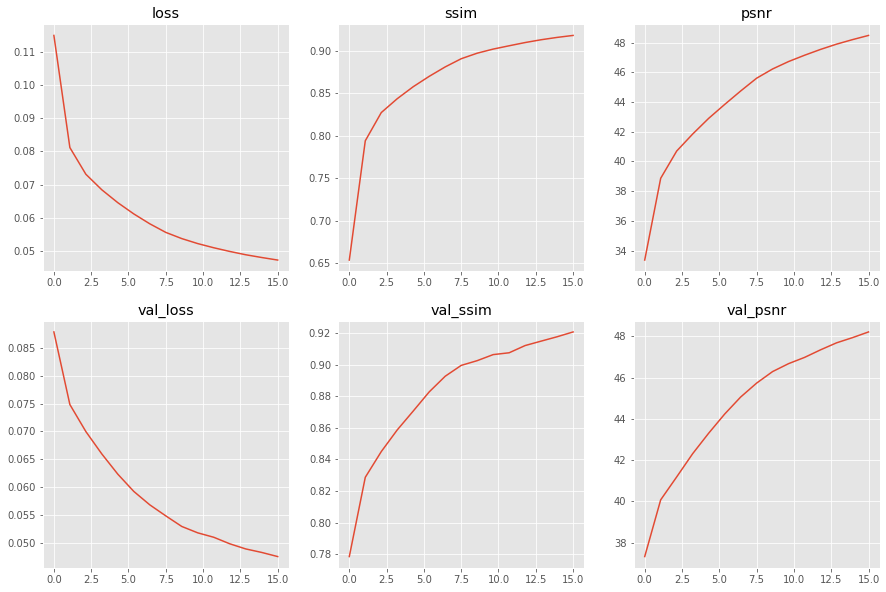

In [ ]:
Visualization(baseline_results)

### Visualization on test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


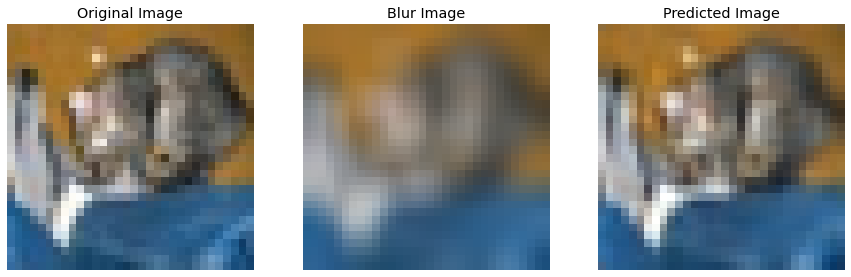

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


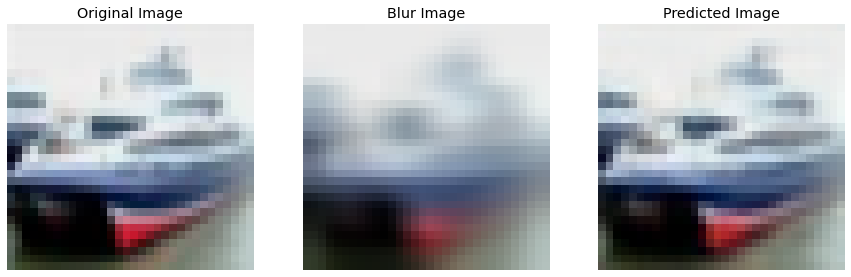

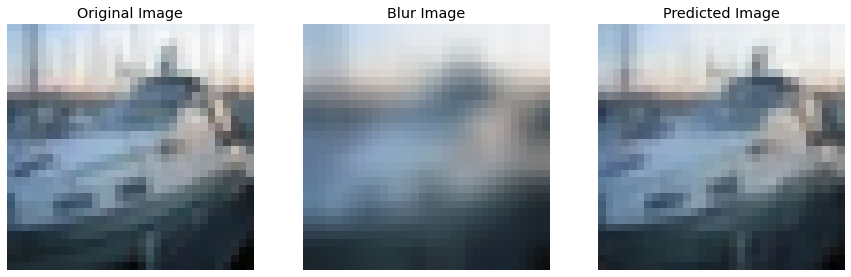

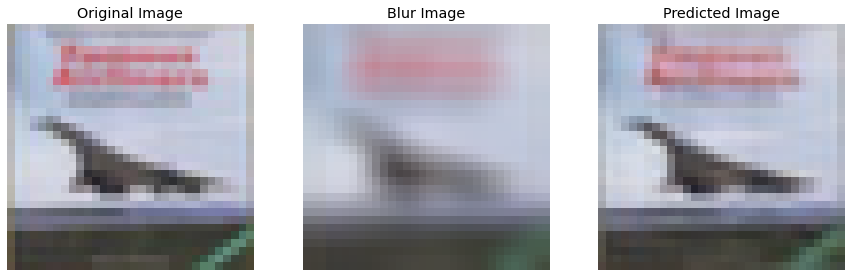

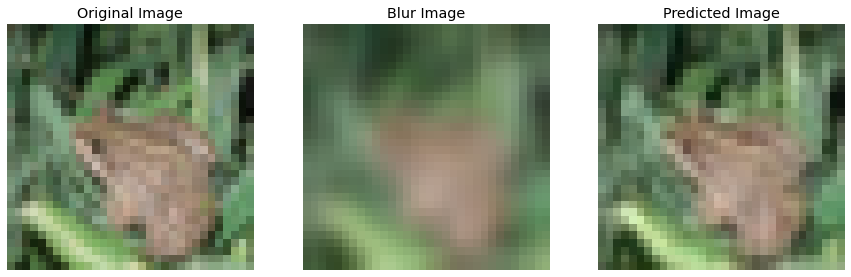

In [ ]:
for i, dt in enumerate(test_blur_clear):
  inp, label = dt[0].to(device), dt[1].to(device)
  pred = baseline_model(inp)
  display(inp.cpu().data, label.cpu().data, pred.cpu().data)
  if i == 4:
    break